In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
os.environ["KERAS_BACKEND"] = "tensorflow"

import uproot
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import networkx as nx
import copy
import math
import keras
import glob
import sys
import datetime

Using TensorFlow backend.


In [20]:
from itertools import combinations

In [2]:
%matplotlib inline

In [3]:
def get_index_triu_vector(i, j, vecsize):
    k = j - i - 1
    k += i*vecsize
    missing = int(i*(i+1)/2)
    k -= missing
    return k

In [4]:
fn = "../data/TTbar/step3_AOD_1.root"
fi = uproot.open(fn)
tree = fi.get("pftree")
data = tree.arrays(tree.keys())
data = {str(k, 'ascii'): v for k, v in data.items()}

In [5]:
len(data["nclusters"])

500

Text(0.5, 0, 'number of objects')

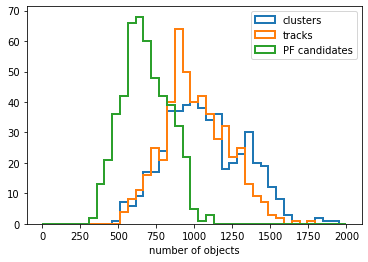

In [8]:
bins = np.linspace(0,2000,40)
plt.hist(data["nclusters"], bins=bins, histtype="step", lw=2, label="clusters");
plt.hist(data["ntracks"], bins=bins, histtype="step", lw=2, label="tracks");
plt.hist(data["npfcands"], bins=bins, histtype="step", lw=2, label="PF candidates");
plt.legend(loc="best")
plt.xlabel("number of objects")

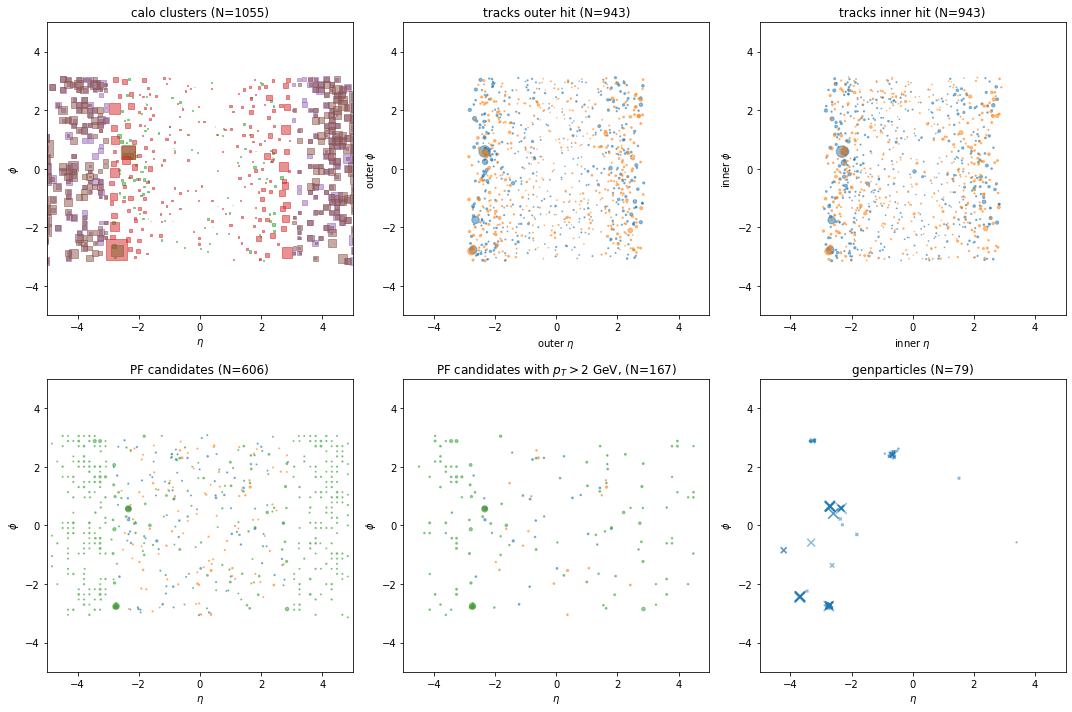

In [13]:
#Event number to plot
i = 2

#minimum pt of the pf candidate
pfcand_ptcut = 2


c_eta = data["clusters_eta"]
c_phi = data["clusters_phi"]
c_en = data["clusters_energy"]
c_type = data["clusters_type"]

t_o_eta = data["tracks_outer_eta"]
t_o_phi = data["tracks_outer_phi"]
t_i_eta = data["tracks_inner_eta"]
t_i_phi = data["tracks_inner_phi"]
t_q = np.sign(data["tracks_qoverp"])
t_en = 1.0/np.abs(data["tracks_qoverp"])

cand_eta = data["pfcands_eta"]
cand_phi = data["pfcands_phi"]
cand_en = data["pfcands_pt"]
cand_charge = data["pfcands_charge"]

g_eta = data["genparticles_eta"]
g_phi = data["genparticles_phi"]
g_en = data["genparticles_pt"]

plt.figure(figsize=(15,10))

ax = plt.subplot(2,3,1)
for ct in [2,3,4,5,8,9,11]:
    cluster_type_sel = c_type[i]==ct
    plt.scatter(
        c_eta[i][cluster_type_sel],
        c_phi[i][cluster_type_sel],
        s=c_en[i][cluster_type_sel],
        marker="s", alpha=0.5, label="{0}".format(ct))
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.title("calo clusters (N={0})".format(len(c_eta[i])))
plt.xlim(-5,5)
plt.ylim(-5,5)
#plt.legend(loc="best", ncol=2)

ax = plt.subplot(2,3,2)
for track_charge in [-1, 1]:
    track_charge_sel = t_q[i] == track_charge
    plt.scatter(t_o_eta[i][track_charge_sel], t_o_phi[i][track_charge_sel], s=t_en[i][track_charge_sel], marker="o", alpha=0.5)
plt.xlabel("outer $\eta$")
plt.ylabel("outer $\phi$")
plt.title("tracks outer hit (N={0})".format(len(t_o_eta[i])))
plt.xlim(-5,5)
plt.ylim(-5,5)

ax = plt.subplot(2,3,3)
for track_charge in [-1, 1]:
    track_charge_sel = t_q[i] == track_charge
    plt.scatter(t_i_eta[i][track_charge_sel], t_i_phi[i][track_charge_sel], s=t_en[i][track_charge_sel], marker="o", alpha=0.5)
plt.xlabel("inner $\eta$")
plt.ylabel("inner $\phi$")
plt.title("tracks inner hit (N={0})".format(len(t_o_eta[i])))
plt.xlim(-5,5)
plt.ylim(-5,5)

ax = plt.subplot(2,3,4)
for _cand_charge in [-1, 1, 0]:
    cand_charge_sel = cand_charge[i] == _cand_charge
    plt.scatter(cand_eta[i][cand_charge_sel], cand_phi[i][cand_charge_sel], s=cand_en[i][cand_charge_sel], marker="o", alpha=0.5)
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.title("PF candidates (N={0})".format(len(cand_eta[i])))
plt.xlim(-5,5)
plt.ylim(-5,5)

ax = plt.subplot(2,3,5)
cand_pt_sel = (cand_en[i] > pfcand_ptcut)
for _cand_charge in [-1, 1, 0]:
    cand_charge_sel = (cand_charge[i] == _cand_charge) & (cand_pt_sel)
    plt.scatter(
        cand_eta[i][cand_charge_sel],
        cand_phi[i][cand_charge_sel],
        s=cand_en[i][cand_charge_sel], marker="o", alpha=0.5)
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.title("PF candidates with $p_T > {0}$ GeV, (N={1})".format(pfcand_ptcut, len(cand_eta[i][cand_pt_sel])))
plt.xlim(-5,5)
plt.ylim(-5,5)

ax = plt.subplot(2,3,6)
plt.scatter(g_eta[i], g_phi[i], s=g_en[i], marker="x", alpha=0.5)
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.title("genparticles (N={0})".format(len(g_eta[i])))

plt.xlim(-5,5)
plt.ylim(-5,5)
plt.tight_layout()

In [14]:
from collections import Counter

In [15]:
all_blocks_counts_0 = []
all_blocks_counts_1 = []
all_blocks_counts_2 = []
all_blocks_counts_3 = []

for iev in range(len(data["clusters_iblock"])):
    bls = list(data["clusters_iblock"][iev])
    bls2 = list(data["tracks_iblock"][iev])
    bls_counts = sorted([v for k, v in Counter(bls+bls2).items()], reverse=True)
    all_blocks_counts_0 += [bls_counts[0]]
    all_blocks_counts_1 += [bls_counts[1]]
    all_blocks_counts_2 += [bls_counts[2]]
    all_blocks_counts_3 += [bls_counts[3]]

In [16]:
len(np.unique(list(data["clusters_iblock"][iev]) + list(data["tracks_iblock"][iev])))

601

Text(0.5, 0, 'elements per block')

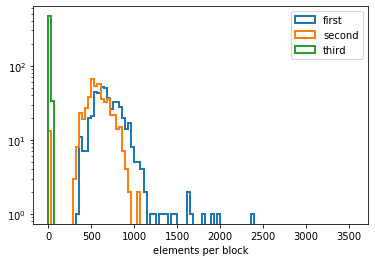

In [17]:
bins = np.linspace(0,1.5*max(all_blocks_counts_0), 100)
plt.hist(all_blocks_counts_0, bins=bins, histtype="step", lw=2, label="first")
plt.hist(all_blocks_counts_1, bins=bins, histtype="step", lw=2, label="second")
plt.hist(all_blocks_counts_2, bins=bins, histtype="step", lw=2, label="third")

plt.yscale("log")
plt.legend(loc="best")
plt.xlabel("elements per block")

In [18]:
tree2 = fi.get("linktree")
linkdata = tree2.arrays(tree2.keys())
linkdata = {str(k, 'ascii'): v for k, v in linkdata.items()}

In [21]:
pfgraph = nx.Graph()
iev = 2

items_block = {}
node_pos = {}
node_colors = {}
node_sizes = {}
node_types = {}

cluster_colors = {
    3: "blue",
    2: "blue",
    5: "red",
    4: "green",
    8: "orange",
    9: "orange",
    11: "purple",
}

for icluster, iblock in enumerate(data["clusters_iblock"][iev]):
    this = (iblock, data["clusters_ielem"][iev][icluster])
    pfgraph.add_node(this)
    
    node_pos[this] = (data["clusters_eta"][iev][icluster], data["clusters_phi"][iev][icluster])
    tp = data["clusters_type"][iev][icluster]
    node_colors[this] = cluster_colors[tp]
    node_sizes[this] = data["clusters_energy"][iev][icluster]
    if not iblock in items_block.keys():
        items_block[iblock] = []
    items_block[iblock] += [this]
    node_types[this] = tp
    
for itrack, iblock in enumerate(data["tracks_iblock"][iev]):
    this = (iblock, data["tracks_ielem"][iev][itrack])
    pfgraph.add_node(this)
    
    p = abs(data["tracks_qoverp"][iev][itrack])
    eta = data["tracks_outer_eta"][iev][itrack]
    phi = data["tracks_outer_phi"][iev][itrack]
    node_pos[this] = (
        eta, phi
    )
    node_colors[this] = "black"
    node_sizes[this] = 10*p
    node_types[this] = 0

    if not iblock in items_block.keys():
        items_block[iblock] = []
    items_block[iblock] += [this]
    
for iblock, items in items_block.items():
    for comb in combinations(items, 2):
        pfgraph.add_edge(comb[0], comb[1])

Text(0, 0.5, '$\\phi$')

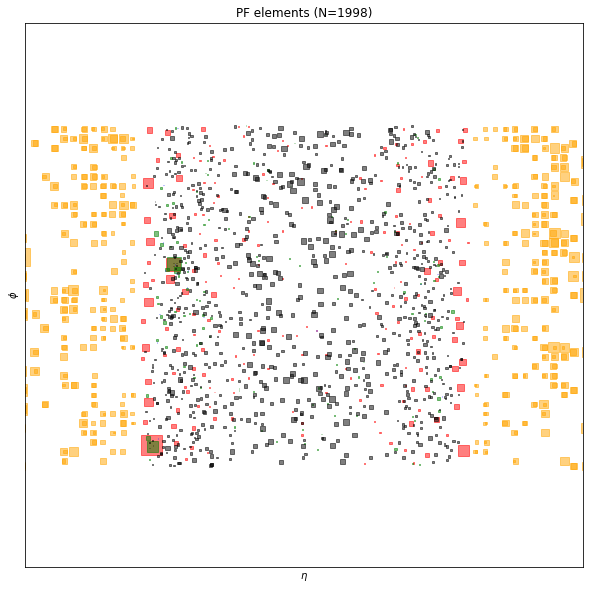

In [22]:
plt.figure(figsize=(10, 10))
plt.xlim(-5,5)
plt.ylim(-5,5)
nx.draw(pfgraph,
        pos=node_pos,
        node_size=[node_sizes[n] for n in pfgraph.nodes],
        node_color=[node_colors[n] for n in pfgraph.nodes],
        edgelist=[],
        node_shape="s",
        alpha=0.5, width=0.05
)
plt.title("PF elements (N={0})".format(len(pfgraph.nodes)))
plt.axis('on')
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")

/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


Text(0, 0.5, '$\\phi$')

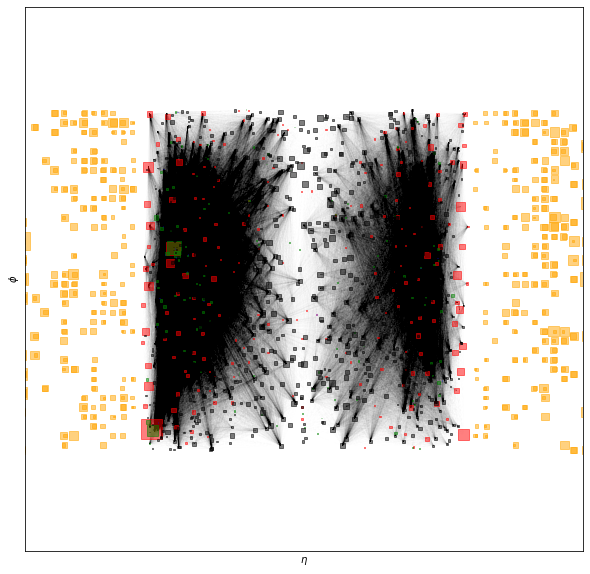

In [23]:
plt.figure(figsize=(10, 10))
plt.xlim(-5,5)
plt.ylim(-5,5)
nx.draw(pfgraph,
        pos=node_pos,
        node_size=[node_sizes[n] for n in pfgraph.nodes],
        node_color=[node_colors[n] for n in pfgraph.nodes],
        node_shape="s",
        alpha=0.5, width=0.001
)
#plt.xticks(np.arange(-5,5,0.3))
#plt.yticks(np.arange(-5,5,0.3))

#plt.grid()
# plt.xlabel("cluster x / scaled track px")
# plt.ylabel("cluster y / scaled track px")
# plt.title("PF elements with blocks")
plt.axis('on')
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")

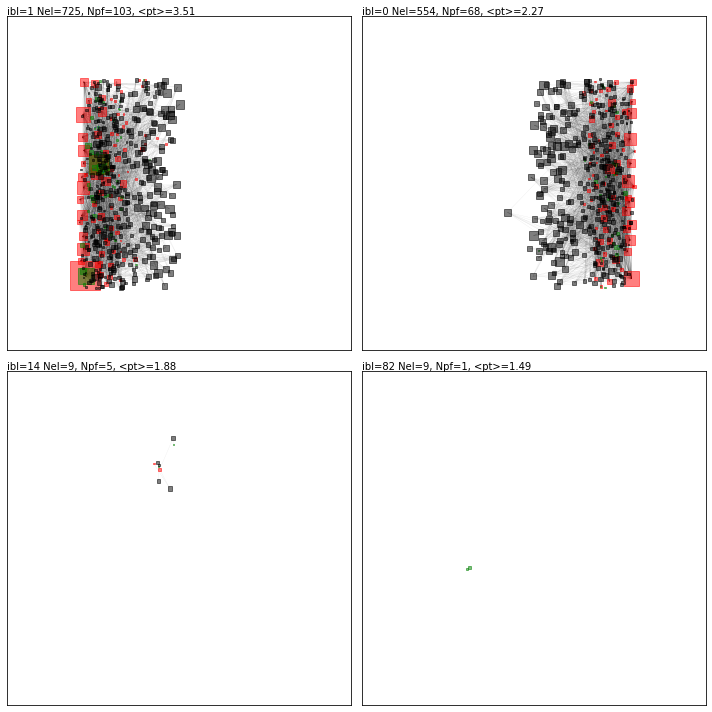

In [24]:
biggest_clusters = sorted([
    (k, items_block[k]) for k in items_block.keys()], reverse=True, key=lambda x: len(x[1])
)[:4]

plt.figure(figsize=(10, 10))
iplot = 1

subs = []
for iblock, elems in biggest_clusters:
    nelem = len(elems)
    
    sub = nx.Graph()
    sub.add_nodes_from(items_block[iblock])
    
    n = linkdata["linkdata_nelem"][iev][linkdata["linkdata_iblock"][iev] == iblock]
    ks = linkdata["linkdata_k"][iev][linkdata["linkdata_iblock"][iev] == iblock]
    dists = linkdata["linkdata_distance"][iev][linkdata["linkdata_iblock"][iev] == iblock]
    kdict = {k: i for i, k in enumerate(ks)}

    vecsize = n[0]
    inds = np.triu_indices(n=vecsize, m=vecsize, k=0.1)
    inds2 = [get_index_triu_vector(i, j, vecsize) for i, j in zip(inds[0], inds[1])]
    for i, ind2 in enumerate(inds2):
        if ind2 in kdict.keys():
            idx_triu_i = inds[0][i]
            idx_triu_j = inds[1][i]
            if idx_triu_j > idx_triu_i:
                tmp = idx_triu_i
                idx_triu_i = idx_triu_j
                idx_triu_j = tmp
            u = (iblock, idx_triu_i)
            v = (iblock, idx_triu_j)
            if u in sub.nodes and v in sub.nodes:
                sub.add_edge(u, v, weight=dists[kdict[ind2]])
    subs += [sub]
    
    ax = plt.subplot(2,2,iplot)

    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    nx.draw(sub,
            pos=node_pos,
            node_size=[2*node_sizes[n] for n in sub.nodes],
            node_color=[node_colors[n] for n in sub.nodes],
            node_shape="s",
            alpha=0.5, width=0.05, ax=ax
    )
    
    pfcand_inds = (data["pfcands_iblock"][iev] == iblock)
    pf_pt = data["pfcands_pt"][iev][pfcand_inds]
    pf_phi = data["pfcands_phi"][iev][pfcand_inds]
    
    plt.text(0.0, 1.0,
        "ibl={0} Nel={1}, Npf={2}, <pt>={3:.2f}".format(
            iblock, nelem, len(pf_pt), np.mean(pf_pt)),
            transform=ax.transAxes, verticalalignment="bottom")
#     pf_x = 5*pf_pt * np.cos(pf_phi)
#     pf_y = 5*pf_pt * np.sin(pf_phi)
    
#     for ipf in range(len(pf_x)):
#         plt.plot([0, pf_x[ipf]], [0, pf_y[ipf]], color="blue")
    plt.axis('on')
    iplot += 1
    
plt.tight_layout()

In [25]:
iev = 3
track_outer_eta = data["tracks_outer_eta"][iev]
track_outer_phi = data["tracks_outer_phi"][iev]

track_inner_eta = data["tracks_inner_eta"][iev]
track_inner_phi = data["tracks_inner_phi"][iev]

cl_ecal = data["clusters_type"][iev] == 4
cl_ecal_eta = data["clusters_eta"][iev][cl_ecal]
cl_ecal_phi = data["clusters_phi"][iev][cl_ecal]

cl_hcal = data["clusters_type"][iev] == 5
cl_hcal_eta = data["clusters_eta"][iev][cl_hcal]
cl_hcal_phi = data["clusters_phi"][iev][cl_hcal]

cl_hf = data["clusters_type"][iev] >= 8
cl_hf_eta = data["clusters_eta"][iev][cl_hf]
cl_hf_phi = data["clusters_phi"][iev][cl_hf]

(-5, 5)

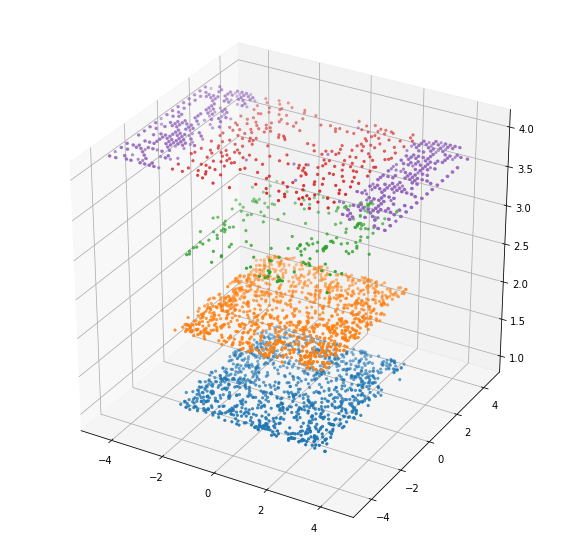

In [26]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(track_inner_eta, track_inner_phi, 1, marker=".")
ax.scatter3D(track_outer_eta, track_outer_phi, 2, marker=".")
ax.scatter3D(cl_ecal_eta, cl_ecal_phi, 3, marker=".")
ax.scatter3D(cl_hcal_eta, cl_hcal_phi, 4, marker=".")
ax.scatter3D(cl_hf_eta, cl_hf_phi, 4, marker=".")

plt.xlim(-5,5)
plt.ylim(-5,5)